## setup

In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [2]:
# soc = QickSoc('/home/xilinx/jupyter_notebooks/fw/2025-06-15_216_tprocv2r24_standard/qick_216.bit')
# soc = QickSoc('/home/xilinx/jupyter_notebooks/fw/qick_tprocv2_216_standard_1ch_250828_2/qick_216.bit')
# soc = QickSoc('/home/xilinx/jupyter_notebooks/fw/qick_tprocv2_216_standard_1ch_250829_2/qick_216.bit')
soc = QickSoc('/home/xilinx/jupyter_notebooks/fw/qick_tprocv2_216_standard_1ch_251021_1/qick_216.bit')

# soc = QickSoc('/home/xilinx/jupyter_notebooks/fw/qick_tprocv2_111_standard_250801_1/qick_111.bit')
# soc = QickSoc('/home/xilinx/jupyter_notebooks/fw/qick_tprocv2_111_standard_1ch_251020_1/qick_111.bit')

soccfg = soc
print(soccfg)

QICK running on ZCU216, software version 0.2.371

Firmware configuration (built Tue Oct 21 16:43:27 2025):

	Global clocks (MHz): tProc dispatcher timing 430.080, RF reference 245.760
	Groups of related clocks: [tProc timing clock, DAC tile 1, DAC tile 2, DAC tile 3], [DAC tile 0], [ADC tile 2]

	1 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 65536 complex samples (6.838 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228 on JHC1, or QICK box DAC port 0

	1 readout channels:
	0:	axis_dyn_readout_v1 - configured by tProc output 4
		fs=2457.600 Msps, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		axis_avg_buffer v1.2 (has edge counter, no weights)
		memory 8192 accumulated, 4096 decimated (13.333 us)
		triggered by tport 10, pin 0, feedback to tProc input 0
		ADC tile 2, blk 0 is 0_226 on JHC7, or QICK box ADC port 4

	8 digital output pins:
	0:	PMOD0_0_LS
	1:	PMOD0_1_LS
	2:	PMOD0_2_LS
	3:	PMOD0_3_LS
	4

## Randomized Benchmarking
RB sequence generator: based on https://github.com/openquantumhardware/devForLBNL/blob/master/RB_code_demo/20220201-3DTransmon-Chacracterization%2BRB.ipynb


In [21]:
import random, time
from qick.asm_v2 import AcquireProgramV2, AveragerProgramV2, AsmV2, AsmInst
from qick.tprocv2_assembler import LFSR

class RBSequenceProgram(AveragerProgramV2):

    def _initialize(self, cfg):

        t=time.time_ns(); dbg_i=0

        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']

        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_reg(name='lfsr_seed')
        self.add_reg(name='seq_length')


        self.gates_set = cfg['gates_set']

        if cfg['pulse_len_us']:
            self.gauss_len = cfg['pulse_len_us']
        else:
            # If None generate minimum length gaussian pulses
            self.gauss_len = self.cycles2us(3, gen_ch=gen_ch)
            # self.gauss_len = self.cycles2us(100, gen_ch=gen_ch)
        self.add_gauss(ch=gen_ch, name="gauss_env", sigma=self.gauss_len/10, length=self.gauss_len, even_length=False)
    
        """This adds the different types of pulses to the pulse library which can be played on demand later"""
        gates_print = ""
        for gate_idx, gate in enumerate(self.gates_set):
            gates_print += "%0d: %s ; "%(gate_idx, gate['gate_symbol'])
            # print("%0d: %s"%(gate_idx, gate['gate_symbol']))
            ginfo = gate['gate_pulse']
            self.add_pulse(ch=gen_ch, name=gate['gate_symbol'],
                           style    = ginfo["style"],
                           envelope = ginfo["envelope"],
                           freq     = ginfo["freq"],
                           phase    = ginfo["phase"],
                           gain     = ginfo["gain"],
                        )
        if cfg['verbose']:
            print(gates_print)

        # Pulse for Readout
        self.add_pulse(ch=gen_ch, name="ro_pulse", ro_ch=ro_ch, 
                       style    = "const", 
                       freq     = cfg['freq'], 
                    #    length   = 1.0, 
                       length   = 0.1, 
                       phase    = 0,
                       gain     = 0.2,
                    )

        # For debug, pulse to signal end of sequence
        self.add_pulse(ch=gen_ch, name="end_seq_pulse", ro_ch=ro_ch, 
                       style    = "const", 
                       freq     = cfg['freq'], 
                       length   = 0.1, 
                       phase    = 0,
                       gain     = 0.2,
                    )

        # Subroutine to generate random sequence using tProc LFSR
        sub_gen_rnd_seq = AsmV2()
        if sub_gen_rnd_seq and cfg['use_lfsr']:
            # Initialize Seed of LFSR (write s1/s_rand with seed literal)
            sub_gen_rnd_seq.write_reg(dst='s_rand', src='lfsr_seed')
            # Initialize virtual-Z gate phase accumulator (r10)
            sub_gen_rnd_seq.write_reg(dst='r10', src=0)

            # Get Random Gate index
            sub_gen_rnd_seq.label('gen_seq_loop')

            sub_gen_rnd_seq.cond_jump(label='gen_seq_end', arg1='seq_length', test='Z', op='-', arg2=0)

            # Read LFSR (read s1/s_rand) and trunc to 4 lsbs
            sub_gen_rnd_seq.append_macro(AsmInst(inst={'CMD':"REG_WR", 'DST': 'r4', 'SRC':'op', 'OP': 's1 AND #h0F'}, addr_inc=1))
            ## Check if index is within Set Range (r4 - arg2(set_size) < 0)
            sub_gen_rnd_seq.cond_jump(label='gen_seq_loop', arg1='r4', test='NS', op='-', arg2=10)  # arg2: size of gates set

            # Check if Z gate
            sub_gen_rnd_seq.label('gen_seq_checkZ')
            sub_gen_rnd_seq.cond_jump(label='gen_seq_checkZov2', arg1='r4', test='NZ', op='-', arg2=1)  # arg2: index of Z in the gates set
            ## Increment Z-phase accumulator r10
            sub_gen_rnd_seq.inc_reg(dst='r10', src='r9')
            sub_gen_rnd_seq.inc_reg(dst='r10', src='r9')
            sub_gen_rnd_seq.jump(label='gen_seq_pulse')

            # Check if Z/2 gate
            sub_gen_rnd_seq.label('gen_seq_checkZov2')
            sub_gen_rnd_seq.cond_jump(label='gen_seq_check-Zov2', arg1='r4', test='NZ', op='-', arg2=4)  # arg2: index of Z/2 in the gates set
            ## Increment Z-phase accumulator r10
            sub_gen_rnd_seq.append_macro(AsmInst(inst={'CMD':"REG_WR", 'DST': 'r10', 'SRC':'op', 'OP': 'r10 + r9'}, addr_inc=1))
            sub_gen_rnd_seq.jump(label='gen_seq_pulse')

            # Check if -Z/2 gate
            sub_gen_rnd_seq.label('gen_seq_check-Zov2')
            sub_gen_rnd_seq.cond_jump(label='gen_seq_pulse', arg1='r4', test='NZ', op='-', arg2=7)  # arg2: index of -Z/2 in the gates set
            ## Increment Z-phase accumulator r10
            sub_gen_rnd_seq.append_macro(AsmInst(inst={'CMD':"REG_WR", 'DST': 'r10', 'SRC':'op', 'OP': 'r10 - r9'}, addr_inc=1))

            # Send pulse to Wave Dispatcher
            sub_gen_rnd_seq.label('gen_seq_pulse')
            ## Write r_wave with corresponding waveform from wmem address
            sub_gen_rnd_seq.append_macro(AsmInst(inst={'CMD':"REG_WR", 'DST': 'r_wave', 'SRC':'wmem', 'ADDR':'r4'}, addr_inc=1))
            ## Update r_wave phase w1 with Z-phase accumulator
            sub_gen_rnd_seq.append_macro(AsmInst(inst={'CMD':"REG_WR", 'DST': 'w1', 'SRC':'op', 'OP': 'w1 + r10'}, addr_inc=1))
            ## Write r_wave to WPORT
            sub_gen_rnd_seq.append_macro(AsmInst(inst={'CMD':"WPORT_WR", 'DST': str(cfg['gen_ch']), 'SRC':'r_wave'}, addr_inc=1))

            # Repeat L times
            sub_gen_rnd_seq.label('gen_seq_next_gate')
            sub_gen_rnd_seq.inc_reg(dst='seq_length', src=-1)
            # sub_gen_rnd_seq.cond_jump(label='gen_seq_loop', arg1='seq_length', test='NZ', op='-', arg2=0)
            sub_gen_rnd_seq.jump(label='gen_seq_loop')

            sub_gen_rnd_seq.label('gen_seq_end')

            # End of subroutine
            self.add_subroutine("gen_rnd_seq", sub_gen_rnd_seq)

        # Configure Readout
        self.add_readoutconfig(ch=ro_ch, name="measure", freq=cfg['freq'], gen_ch=gen_ch)

        # send the config to the dynamic RO
        self.send_readoutconfig(ch=cfg['ro_ch'], name="measure", t=0.0)

        t=time.time_ns(); 
        # print('    // DBG RB initialize(): %0d - %0d ns' % (dbg_i, time.time_ns()-t)); t=time.time_ns(); dbg_i+=1


    def _body(self, cfg):
        t=time.time_ns(); dbg_i=0
        # print('    // DBG RB body() start: %0d - %0d ns' % (dbg_i, time.time_ns()-t)); t=time.time_ns(); dbg_i+=1

        ## N_G: number of different gates sequences: e.g.: 5
        N_G = cfg['N_G']
        ## N_L: number of length of the sequences - e.g.: 3
        N_L = cfg['N_L']
        ## l: length of sequences - e.g.: [10, 100, 1000]
        L = cfg['L']
        ## N_E: number of times the same sequence is applied
        N_E = cfg['N_E']

        # Initialize total iterations counter (for debug)
        self.write_reg(dst='r8', src=0)
        # Convert 90deg to phase representation value in r9
        self.write_reg(dst='r9', src=self.deg2reg(deg=90, gen_ch=self.cfg["gen_ch"]))

        # Wait for 1us from reference_time
        self.delay(1.0)

        # Pause tProc until absolute time matches reference time (mainly to align stages in simulation)
        self.wait(0.0)

        # Iterate over different sequences
        for n_g in range(0, N_G):
            
            # Iterate over different lengths
            for n_l in range(0, N_L):
                dbg_i=0
                # Generate a random sequence of length l
                if cfg['lfsr_seed']:
                    seed = cfg['lfsr_seed']
                else:
                    seed = np.random.randint(123456789,987654321)
                # print('Sequence Seed: %0d' % (seed))

                t=time.time_ns(); 
                if cfg['test_seq']:
                    depth = len(cfg['test_seq'])
                    self.gate_seq = cfg['test_seq']
                else:
                    depth = L[n_l]
                    self.gate_seq = self.generate_rbsequence(depth=depth, gates_set=self.gates_set, use_lfsr=cfg['use_lfsr'], lfsr_seed=seed)
                # print('    // DBG generate_rbsequence: %0d - %0d ns' % (dbg_i, time.time_ns()-t)); t=time.time_ns(); dbg_i+=1


                self.seq_load_time = len(self.gate_seq) * 40 * 0.005
                self.seq_play_time = len(self.gate_seq) * self.gauss_len

                # for n_e in range(0, N_E):
                for n_e in range(0, 1):
                # self.open_loop(n=N_E, name='N_E_loop_%0d'%(n_g*N_L+n_l))
                # if (True):  # just to indent

                    if cfg['verbose']:
                        print(self.gate_seq)    # for debug
                        print('Sequence Load Time: %0.3f us'%(self.seq_load_time))
                        print('Sequence Play Time: %0.3f us'%(self.seq_play_time))

                    if cfg['use_lfsr']:
                        # Delay start of play sequence
                        ## Increase reference_time in delay time (delay should be the estimated time in takes to write the full sequence in the dispatcher)
                        self.delay(self.seq_load_time, tag='pre_seq_delay_%0d%0d%0d'%(n_g,n_l,n_e))
                        # self.delay(self.seq_load_time, tag='pre_seq_delay_%0d%0d%0d'%(n_g,n_l,0))

                    if not cfg['use_lfsr']:
                        self.phase_ref = 0
                        self.write_reg(dst='r10', src=0)
                        for gate_symbol in self.gate_seq:
                            """For the Z gates (virtual rotation), we need to advance the phase of all the pulses which follows afterwards"""
                            if gate_symbol == "Z":
                                self.phase_ref += 180
                                self.inc_reg(dst='r10', src=self.deg2reg(deg=180, gen_ch=self.cfg["gen_ch"]))
                                # self.call("virt_z")
                            elif gate_symbol == "Z/2":
                                self.phase_ref += 90
                                self.inc_reg(dst='r10', src=self.deg2reg(deg=90, gen_ch=self.cfg["gen_ch"]))
                                # self.call("virt_z_ov_2")
                            elif gate_symbol == "-Z/2":
                                self.phase_ref += -90
                                self.inc_reg(dst='r10', src=self.deg2reg(deg=-90, gen_ch=self.cfg["gen_ch"]))
                                # self.call("virt_z_ov_2")
                            else:
                                # self.pulse(ch=self.cfg["qubit_ch"], name=gate, phase=deg2reg(self.phase_ref+ginfo["phase"]), gain=ginfo["gain"], play=True)
                                # self.pulse(ch=self.cfg["gen_ch"], name=gate, phase=ginfo["phase"]+self.phase_ref, gain=ginfo["gain"])
                                # self.pulse(ch=self.cfg["gen_ch"], name=gate, t='auto')
                                pass
                            # # Execute always even if Z gate to see the same number of pulses as gates
                            # self.pulse(ch=self.cfg["gen_ch"], name=gate, t='auto')
                            gate_idx = next((idx for idx, gate in enumerate(self.gates_set) if gate['gate_symbol'] == gate_symbol), -1)
                            self.write_reg(dst='r4', src=gate_idx)
                            ## Write r_wave with corresponding waveform from wmem address
                            self.append_macro(AsmInst(inst={'CMD':"REG_WR", 'DST': 'r_wave', 'SRC':'wmem', 'ADDR':'r4'}, addr_inc=1))
                            ## Update r_wave phase w1 with Z-phase accumulator
                            self.append_macro(AsmInst(inst={'CMD':"REG_WR", 'DST': 'w1', 'SRC':'op', 'OP': 'w1 + r10'}, addr_inc=1))
                            ## Write r_wave to WPORT
                            self.append_macro(AsmInst(inst={'CMD':"WPORT_WR", 'DST': str(cfg['gen_ch']), 'SRC':'r_wave'}, addr_inc=1))

                            # print('    // DBG RB gate_seq code NO_LFSR: %0d - %0d ns' % (dbg_i, time.time_ns()-t)); t=time.time_ns(); dbg_i+=1

                    else:
                        # Initialize tProc LFSR, Configure LFSR seed in lfsr_seed
                        self.write_reg(dst='lfsr_seed', src=seed)
                        # Configure Random Sequence Length in seq_length
                        self.write_reg(dst='seq_length', src=depth-1)
                        # Generate Random Sequence - will generate the same sequence as python generate_rbsequence()
                        self.call("gen_rnd_seq")
                        # Add last gate (taken from the python generated sequence)
                        last_gate_idx = next((idx for idx, gate in enumerate(self.gates_set) if gate['gate_symbol'] == self.gate_seq[-1]), -1)
                        # gate = self.gate_seq[-1]
                        # self.pulse(ch=self.cfg["gen_ch"], name=gate, t=0.0)
                        self.write_reg(dst='r4', src=last_gate_idx)
                        ## Write r_wave with corresponding waveform from wmem address
                        self.append_macro(AsmInst(inst={'CMD':"REG_WR", 'DST': 'r_wave', 'SRC':'wmem', 'ADDR':'r4'}, addr_inc=1))
                        ## Update r_wave phase w1 with Z-phase accumulator
                        self.append_macro(AsmInst(inst={'CMD':"REG_WR", 'DST': 'w1', 'SRC':'op', 'OP': 'w1 + r10'}, addr_inc=1))
                        ## Write r_wave to WPORT
                        self.append_macro(AsmInst(inst={'CMD':"WPORT_WR", 'DST': str(cfg['gen_ch']), 'SRC':'r_wave'}, addr_inc=1))

                        # print('    // DBG RB gate_seq code LFSR: %0d - %0d ns' % (dbg_i, time.time_ns()-t)); t=time.time_ns(); dbg_i+=1


                    if cfg['acquire_mode'] == 'DEC':
                        # Generate readout pulse
                        # self.send_readoutconfig(ch=cfg['ro_ch'], name="measure", t=0.0)

                        # Send Readout Pulse
                        self.pulse(ch=cfg["gen_ch"], name='ro_pulse', t=0.0)

                        # Trigger to capture the full sequence before being played
                        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

                    # Delay until the sequence is applied (will be proportional to sequence length)
                    self.delay(self.seq_play_time, tag='post_seq_delay_%0d%0d%0d'%(n_g,n_l,n_e))
                    # self.delay(self.seq_play_time, tag='post_seq_delay_%0d%0d%0d'%(n_g,n_l,0))

                    if cfg['acquire_mode'] == 'AVG':
                        # Generate readout pulse
                        # self.send_readoutconfig(ch=cfg['ro_ch'], name="measure", t=0.0)

                        # Send Readout Pulse
                        self.pulse(ch=cfg["gen_ch"], name='ro_pulse', t=0.0)

                        # Trigger after the sequence has been played
                        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=0.0, ddr4=False)

                    # # Add End of Sequence pulse (for debug)
                    # self.pulse(ch=cfg["gen_ch"], name='end_seq_pulse', t=0.0)

                    # Delay some more time to ensure capture has finished
                    self.delay(1.0)

                    # Pause tProc until absolute time matches reference time (mainly to align stages in simulation)
                    self.wait(0.0)

                    # Increment total iterations counter (for debug)
                    self.inc_reg(dst='r8', src=1)

                # self.close_loop()

            # print('    // DBG RB N_E Loop: %0d - %0d ns' % (dbg_i, time.time_ns()-t)); t=time.time_ns(); dbg_i+=1

    def generate_rbsequence(self, depth, gates_set, use_lfsr=False, lfsr_seed=0):
        """Single qubit RB program to generate a sequence of 'd' gates followed 
            by an inverse gate to bring the qubit back in 'g' state
        """

        """Writing the sequences in terms of Clifford group algebra
            The Clifford gate set forms a closed group => 
            1. Multiplication of any two gates results in a gate part of the group 
            2. Each gate has an inverse
            3. The inverse of a product of multiple Clifford gates is unique
        """
        # gate_symbol = ['I', 'Z', 'X', 'Y', 'Z/2', 'X/2', 'Y/2', '-Z/2', '-X/2', '-Y/2']
        inverse_gate_symbol = ['I', '-Y/2', 'X/2', 'X', 'Y/2', '-X/2']

        # Generate a random gate sequence of a certain depth 'd'
        gates_symbols = [g['gate_symbol'] for g in gates_set]
        gates_set_size = len(gates_set)
        gate_seq_idx = []
        gate_seq = []
        if not use_lfsr:
            gate_seq_idx = np.random.randint(0,gates_set_size,depth-1)
        else:
            lfsr_gen = LFSR()
            lfsr_gen.seed(lfsr_seed)
            idx = lfsr_seed & 0x0F
            for ii in range(depth-1):
                while (idx > gates_set_size-1):
                    idx = lfsr_gen.nxt() & 0x0F
                    # lfsr_gen.print(debug=True)
                gate_seq_idx.append(idx)
                idx = gates_set_size
            # print(gate_seq_idx)
        # Map indexes to gates symbol
        gate_seq = [gates_set[i]['gate_symbol'] for i in gate_seq_idx]

        # Initial node
        a0 = np.matrix([[1], [0], [0], [0], [0], [0]])
        # print('State Initial: ',a0.T)
        anow = a0
        for ii, gate_symbol in enumerate(gate_seq):
            anow = np.dot(gates_set[gates_symbols.index(gate_symbol)]['gate_matrix'], anow)
            # print('State',ii+1,':',anow.T)

        # Get the recover gate
        gate_inverse = inverse_gate_symbol[list(anow).index(max(anow))]
        gate_seq.append(gate_inverse)

        # Calculate final state for check
        anow = np.dot(gates_set[gates_symbols.index(gate_inverse)]['gate_matrix'], anow)
        # print('State Final:',anow.T)

        return gate_seq



0: I ; 1: Z ; 2: X ; 3: Y ; 4: Z/2 ; 5: X/2 ; 6: Y/2 ; 7: -Z/2 ; 8: -X/2 ; 9: -Y/2 ; 
['X/2', '-X/2']
Sequence Load Time: 0.400 us
Sequence Play Time: 0.200 us
['X/2', 'X/2', '-Z/2', '-Y/2', '-Y/2']
Sequence Load Time: 1.000 us
Sequence Play Time: 0.500 us
['X/2', '-X/2']
Sequence Load Time: 0.400 us
Sequence Play Time: 0.200 us
['X/2', 'X/2', '-Z/2', '-Y/2', '-Y/2']
Sequence Load Time: 1.000 us
Sequence Play Time: 0.500 us


  0%|          | 0/1 [00:00<?, ?it/s]

(4, 307, 2)


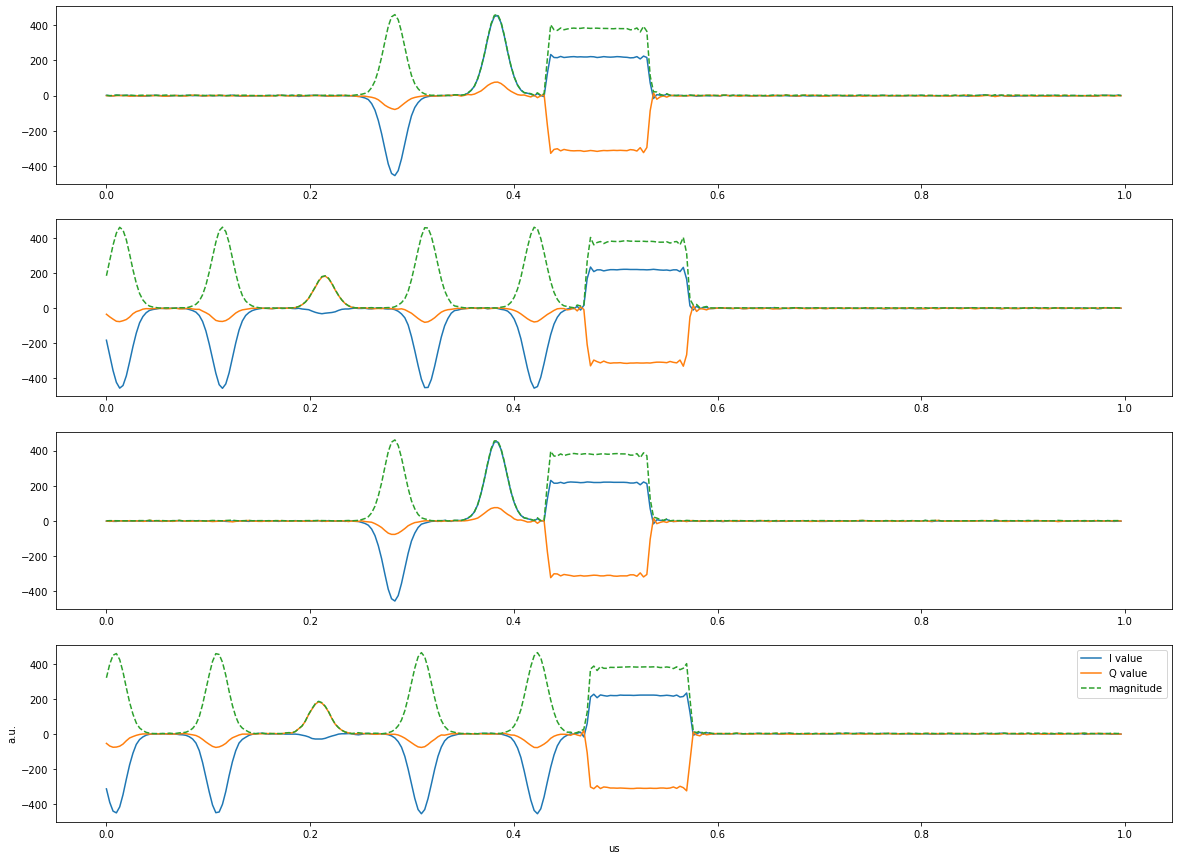

In [22]:
SIM = True
TRIG_TIME = 0.2
FREQ = 500
RO_LEN = 2.0
USE_LFSR = True
LFSR_SEED = 123456789
# LFSR_SEED = None  # use None to randomize the seed from python
ACQUIRE_MODE = 'AVG'    # AVG, DEC
# ACQUIRE_MODE = 'DEC'    # AVG, DEC

if SIM:
    GEN_CH = 0  # DAC228_T0_CH0
    RO_CH = 0   # ADC224_T0_CH0
else:
    GEN_CH = 7  # DAC229_T1_CH3
    RO_CH = 1   # ADC224_T0_CH1

qubit_params = {'pi_gain': 1.0, 'pi_2_gain': 0.5, 'freq': FREQ, 'z_gain': 0.2}

# Define the Gates Set
"""Modeled the bloch sphere as 6-node graph, each rotation in the RB sequence is effectively
exchanging the node label on the bloch sphere.
For example: Z rotation is doing this: (+Z->+Z, -Z->-Z, +X->+Y, +Y->-X, -X->-Y, -Y->+X)
"""
"""Matrix columns are [Z, X, Y, -Z, -X, -Y]"""
GATES_SET = []
GATES_SET.append({  'gate_symbol': 'I',
                    'gate_matrix': np.matrix([[1, 0, 0, 0, 0, 0],
                                              [0, 1, 0, 0, 0, 0],
                                              [0, 0, 1, 0, 0, 0],
                                              [0, 0, 0, 1, 0, 0],
                                              [0, 0, 0, 0, 1, 0],
                                              [0, 0, 0, 0, 0, 1]]
                                            ),
                    'gate_pulse':   {
                                        # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                        # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                        # "phase":0, "gain":0, "style":"arb",
                                        "style":        "arb",
                                        "envelope":     "gauss_env",
                                        "freq":         qubit_params['freq'],
                                        "phase":        0, 
                                        "gain":         0.1, 
                                    }
})
GATES_SET.append({  'gate_symbol': 'Z',
                    'gate_matrix': np.matrix([[1, 0, 0, 0, 0, 0],
                                              [0, 0, 0, 0, 1, 0],
                                              [0, 0, 0, 0, 0, 1],
                                              [0, 0, 0, 1, 0, 0],
                                              [0, 1, 0, 0, 0, 0],
                                              [0, 0, 1, 0, 0, 0]]
                                    ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":0, "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         qubit_params['z_gain'],
                    }
})
GATES_SET.append({  'gate_symbol': 'X',
                    'gate_matrix': np.matrix([[0, 0, 0, 1, 0, 0],
                                              [0, 1, 0, 0, 0, 0],
                                              [0, 0, 0, 0, 0, 1],
                                              [1, 0, 0, 0, 0, 0],
                                              [0, 0, 0, 0, 1, 0],
                                              [0, 0, 1, 0, 0, 0]]
                                    ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":qubit_params['pi_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         qubit_params['pi_gain'], 
                    }
})
GATES_SET.append({  'gate_symbol': 'Y',
                    'gate_matrix': np.matrix([[0, 0, 0, 1, 0, 0],
                                              [0, 0, 0, 0, 1, 0],
                                              [0, 0, 1, 0, 0, 0],
                                              [1, 0, 0, 0, 0, 0],
                                              [0, 1, 0, 0, 0, 0],
                                              [0, 0, 0, 0, 0, 1]]
                                    ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "phase":-90, "gain":qubit_params['pi_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        -90, 
                                "gain":         qubit_params['pi_gain'], 
                    }
})
GATES_SET.append({  'gate_symbol': 'Z/2',
                    'gate_matrix': np.matrix([[1, 0, 0, 0, 0, 0],
                                              [0, 0, 0, 0, 0, 1],
                                              [0, 1, 0, 0, 0, 0],
                                              [0, 0, 0, 1, 0, 0],
                                              [0, 0, 1, 0, 0, 0],
                                              [0, 0, 0, 0, 1, 0]]
                                    ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":0, "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         qubit_params['z_gain'],
                    }
})
GATES_SET.append({  'gate_symbol': 'X/2',
                    'gate_matrix': np.matrix([[0, 0, 1, 0, 0, 0],
                                              [0, 1, 0, 0, 0, 0],
                                              [0, 0, 0, 1, 0, 0],
                                              [0, 0, 0, 0, 0, 1],
                                              [0, 0, 0, 0, 1, 0],
                                              [1, 0, 0, 0, 0, 0]]
                                    ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":qubit_params['pi_2_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         qubit_params['pi_2_gain'], 
                    }
})
GATES_SET.append({  'gate_symbol': 'Y/2',
                    'gate_matrix': np.matrix([[0, 0, 0, 0, 1, 0],
                                              [1, 0, 0, 0, 0, 0],
                                              [0, 0, 1, 0, 0, 0],
                                              [0, 1, 0, 0, 0, 0],
                                              [0, 0, 0, 1, 0, 0],
                                              [0, 0, 0, 0, 0, 1]]
                                    ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":-90, "gain":qubit_params['pi_2_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        -90, 
                                "gain":         qubit_params['pi_2_gain'], 
                    }
})
GATES_SET.append({  'gate_symbol': '-Z/2',
                    'gate_matrix': np.matrix([[1, 0, 0, 0, 0, 0],
                                              [0, 0, 1, 0, 0, 0],
                                              [0, 0, 0, 0, 1, 0],
                                              [0, 0, 0, 1, 0, 0],
                                              [0, 0, 0, 0, 0, 1],
                                              [0, 1, 0, 0, 0, 0]]
                                     ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":0, "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         qubit_params['z_gain'],
                    }
})
GATES_SET.append({  'gate_symbol': '-X/2',
                    'gate_matrix': np.matrix([[0, 0, 0, 0, 0, 1],
                                              [0, 1, 0, 0, 0, 0],
                                              [1, 0, 0, 0, 0, 0],
                                              [0, 0, 1, 0, 0, 0],
                                              [0, 0, 0, 0, 1, 0],
                                              [0, 0, 0, 1, 0, 0]]
                                     ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":180, "gain":qubit_params['pi_2_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        180, 
                                "gain":         qubit_params['pi_2_gain'], 
                    }
})
GATES_SET.append({  'gate_symbol': '-Y/2',
                    'gate_matrix': np.matrix([[0, 1, 0, 0, 0, 0],
                                              [0, 0, 0, 1, 0, 0],
                                              [0, 0, 1, 0, 0, 0],
                                              [0, 0, 0, 0, 1, 0],
                                              [1, 0, 0, 0, 0, 0],
                                              [0, 0, 0, 0, 0, 1]]
                                     ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":90, "gain":qubit_params['pi_2_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        90, 
                                "gain":         qubit_params['pi_2_gain'], 
                    }
})


# Configure tProc LFSR to step on s1/s_rand read
soc.tproc.set_lfsr_cfg(2)

rb_config = {
                'gen_ch'        : GEN_CH,
                'ro_ch'         : RO_CH,
                'ro_len'        : RO_LEN,
                'freq'          : FREQ,
                'trig_time'     : TRIG_TIME,
                'acquire_mode'  : ACQUIRE_MODE,
                'relax_delay'   : 1,
                # 'rounds'        : 1,
                'gates_set'     : GATES_SET,
                'pulse_len_us'  : 0.01,
                'test_seq'      : None,
                'use_lfsr'      : USE_LFSR,
                'lfsr_seed'     : LFSR_SEED,
                'N_G'           : 1,
                'N_L'           : 3,
                'L'             : np.array([1, 3, 5]).dot(1),
                'N_E'           : 1
            }


# # Experiment Settings
# rb_config['L']      = [1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96, 128, 192, 
#                         256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1088, 1152, 1216, 1280, 1344, 1408,
#                         1472, 1536, 1600, 1664, 1728, 1750]
# rb_config['N_L']    = len(rb_config['L'])
# rb_config['N_G']    = 40
# rb_config['N_E']    = 4000

# # Test settings 1a - Averaged Acquire - NO LSFR
# rb_config['acquire_mode']   = 'AVG'
# rb_config['use_lfsr']       = False
# rb_config['L']              = [1, 16, 64, 128, 512, 768, 1024]
# # rb_config['L']            = [1, 16, 64]
# rb_config['L']              = [768, 16, 1]
# # rb_config['L']              = [2, 3]
# rb_config['N_L']            = len(rb_config['L'])
# rb_config['N_G']            = 1   # a.k.a: rounds
# rb_config['N_E']            = 1   # a.k.a: reps
# rb_config['verbose']        = True

# # Test settings 1b - Averaged Acquire - LSFR
# rb_config['acquire_mode']   = 'AVG'
# rb_config['use_lfsr']       = True
# rb_config['L']              = [1, 16, 64, 128, 512, 768, 1024]
# # rb_config['L']            = [1, 16, 64]
# rb_config['L']              = [768, 16, 1]
# # rb_config['L']              = [2, 3]
# rb_config['N_L']            = len(rb_config['L'])
# rb_config['N_G']            = 1   # a.k.a: rounds
# rb_config['N_E']            = 1   # a.k.a: reps
# rb_config['verbose']        = True

# Test settings 2a - Decimation Acquire - NO LFSR
rb_config['acquire_mode']   = 'DEC'
rb_config['ro_len']         = 1.0
rb_config['pulse_len_us']   = 0.1
rb_config['use_lfsr']       = False
rb_config['L']              = [2, 5]
rb_config['N_L']            = len(rb_config['L'])
rb_config['N_G']            = 2   # a.k.a: rounds
rb_config['N_E']            = 1   # a.k.a: reps
rb_config['verbose']        = True

# Test settings 2b - Decimation Acquire - LFSR
rb_config['acquire_mode']   = 'DEC'
rb_config['ro_len']         = 1.0
rb_config['pulse_len_us']   = 0.1
rb_config['use_lfsr']       = True
rb_config['L']              = [2, 5]
rb_config['N_L']            = len(rb_config['L'])
rb_config['N_G']            = 2   # a.k.a: rounds
rb_config['N_E']            = 1   # a.k.a: reps
rb_config['verbose']        = True


prog = RBSequenceProgram(soccfg, reps=rb_config['N_E'], final_delay=rb_config['relax_delay'], cfg=rb_config)


if (rb_config['acquire_mode'] == 'DEC'):
    iq_list = prog.acquire_decimated(soc, rounds=1)
    t = prog.get_time_axis(ro_index=0)

    if rb_config['N_E'] > 1:
        iq_list = iq_list[0]

    print(iq_list[0].shape)

    plt.figure(figsize=[20,15])
    N = len(iq_list[0])
    for trig, iq in enumerate(iq_list[0]):
        plt.subplot(N,1,trig+1)
        plt.plot(t, iq[:,0], label="I value")
        plt.plot(t, iq[:,1], label="Q value")
        plt.plot(t, np.abs(iq.dot([1,1j])), label="magnitude", ls='--')
    plt.legend()
    plt.ylabel("a.u.")
    plt.xlabel("us")


if (rb_config['acquire_mode'] == 'AVG'):
    iq_list = prog.acquire(soc, rounds=1)
    # iq_list = prog.acquire(soc, rounds=rb_config['N_G'])

    print(iq_list[0].shape)

    plt.figure(figsize=[20,10])
    plt.plot(np.abs(iq_list[0].dot([1,1j])), label="magnitude", ls='--', marker='x')
    plt.legend()
    plt.ylabel("a.u.")



In [10]:
# print the program
print(prog)

# generate rtl simulation inputs
prog.print_pmem2hex()
prog.print_wmem2hex()
prog.print_sg_mem(sg_idx=0, gen_file=True)

macros:
	WriteReg(dst='s_core_w1', src=0)
	ConfigReadout(ch=0, name='measure', t=0.0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff56b1c8b0>}, t_regs={'t': 0})
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff56b1cfa0>}, t_regs={'t': 430})
	OpenLoop(n=1, name='reps')
	WriteReg(dst='r8', src=0)
	WriteReg(dst='r9', src=1073741824)
	Delay(t=1.0, auto=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff47e12d40>}, t_regs={'t': 430})
	Wait(t=0.0, auto=False, tag=None, no_warn=False, t_params={'t': <qick.asm_v2.QickParam object at 0xffff4d6fb1f0>}, t_regs={'t': 0})
	Delay(t=2.0, auto=False, tag='pre_seq_delay_000', t_params={'t': <qick.asm_v2.QickParam object at 0xffff487f8850>}, t_regs={'t': 860})
	WriteReg(dst='lfsr_seed', src=123456789)
	WriteReg(dst='seq_length', src=9)
	Call(label='gen_rnd_seq')
	WriteReg(dst='r4', src=2)
	AsmInst(inst={'CMD': 'REG_WR', 'DST': 'r_wave', 'SRC': 'wmem', 'ADD

In [28]:
# from datetime import datetime
import time
import pandas as pd

I2 = []
I2_err = []

rb_config['L']          = [1]
rb_config['N_L']        = len(rb_config['L'])
rb_config['N_G']        = 1   # a.k.a: rounds
rb_config['N_E']        = 1   # a.k.a: reps


# Original Settings
depth_array             = [1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96, 128, 192, 
                           256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1088, 1152, 1216, 1280, 1344, 1408,
                           1472, 1536, 1600, 1664, 1728, 1750]
reps                    = 4000
variety                 = 40


rb_config['relax_delay']    = 500  # us
rb_config['pulse_len_us']   = 0.1

# # Test settings 1
# depth_array                   = [1, 16, 128, 1024]
# rb_config['reps']             = 4000
# variety                       = 2


# Test settings 2a - NO LFSR
rb_config['verbose']        = False
rb_config['use_lfsr']       = False
depth_array                 = [1, 16, 64, 128, 512, 768, 1024]
reps                        = 4000
variety                     = 40

# # Test settings 2b - NO LFSR
# rb_config['verbose']        = False
# rb_config['use_lfsr']       = False
# depth_array                 = [1, 1024]
# reps                        = 4000
# variety                     = 5

# Test settings 3a - LFSR
rb_config['verbose']        = False
rb_config['use_lfsr']       = True
depth_array                 = [1, 16, 64, 128, 512, 768, 1024]
reps                        = 4000
variety                     = 40

# # Test settings 3b - LFSR
# rb_config['verbose']        = False
# rb_config['use_lfsr']       = True
# depth_array                 = [1, 1024]
# reps                        = 4000
# variety                     = 5

# # Test settings 4 - LFSR
# rb_config['verbose']        = False
# rb_config['use_lfsr']       = True
# depth_array                 = [1, 5000]
# reps                        = 4000
# variety                     = 5

# # Test settings 4 - LFSR
# rb_config['verbose']        = False
# rb_config['use_lfsr']       = True
# depth_array                 = [10]
# reps                        = 4000
# variety                     = 5

# Code
t_start_ns = time.time_ns()
print('- Experiment Start Time: %0d ns' % (time.time_ns()-t_start_ns))

th = -30

t=time.time_ns()

# Loop for different lengths
for d in depth_array:
    dbg_i=0
    t_sequence_start_ns = time.time_ns()
    print('  - Depth array %0d - time elapsed: %0d ns' % (d,t_sequence_start_ns-t_start_ns) )
    i2_temp = []
    t_runtime_total_ns = 0
    # Loop for different random sequences
    print('    - Sequence run time: ', end=" ")
    for jj in range(variety):
        # print('// DBG start: %0d - %0d ns' % (dbg_i, time.time_ns()-t)); t=time.time_ns(); dbg_i+=1

        rb_config['test_seq'] = prog.generate_rbsequence(depth=d, gates_set=rb_config['gates_set'])
        # print('// DBG gen_seq: %0d - %0d ns' % (dbg_i, time.time_ns()-t)); t=time.time_ns(); dbg_i+=1

        rb_prog = RBSequenceProgram(soccfg, reps=reps, final_delay=rb_config['relax_delay'], cfg=rb_config)
        # print('// DBG RBSeqProgram: %0d - %0d ns' % (dbg_i, time.time_ns()-t)); t=time.time_ns(); dbg_i+=1

        t_runtime_start_ns = time.time_ns()
        # avgi0, avgq0, avgi1, avgq1  = rb_prog.acquire(soc, load_pulses=True, progress=False, debug=False, single_shot=True)
        # adc1, adc2 = rb_prog.acquire(soc, progress=False)
        adc1 = rb_prog.acquire(soc, progress=False)
        t_runtime_end_ns = time.time_ns()
        t_runtime_total_ns += (t_runtime_end_ns-t_runtime_start_ns)
        print(' (%0d): %0d ms' % (jj, (t_runtime_end_ns-t_runtime_start_ns)/1e6), end=" ")

        # print('// DBG acquire: %0d - %0d ns' % (dbg_i, time.time_ns()-t)); t=time.time_ns(); dbg_i+=1
        
        avgi0 = np.array([adc1[0][0][0]])
        avgq0 = np.array([adc1[0][0][1]])
        # avgi1 = adc2[0]
        # avgq1 = adc2[1]
        df = pd.DataFrame(avgi0, columns=['data'])
        g = df['data'].apply(lambda x: 0 if x < th else 1).mean()
        i2_temp.append(g) 
        # print('// DBG append: %0d - %0d ns' % (dbg_i, time.time_ns()-t)); t=time.time_ns(); dbg_i+=1

    print('')
    I2.append(np.mean(i2_temp))
    I2_err.append(np.std(i2_temp)/np.sqrt(variety))
    t_sequence_end_ns = time.time_ns()
    print('    - Sequence Total time: %0d ms (Run time: %0d ms - Overhead time: %0d ms)' % ((t_sequence_end_ns - t_sequence_start_ns)/1e6, t_runtime_total_ns/1e6, (t_sequence_end_ns - t_sequence_start_ns)/1e6 - t_runtime_total_ns/1e6))

t_end_ns = int(time.time_ns())
print('- End Time: %0d - elapsed: %0d' % (t_end_ns, (t_end_ns-t_start_ns)))


- Experiment Start Time: 255602 ns
  - Depth array 1 - time elapsed: 3002402 ns
    - Sequence run time:   (0): 2023 ms  (1): 2021 ms  (2): 2021 ms  (3): 2021 ms  (4): 2021 ms  (5): 2021 ms  (6): 2025 ms  (7): 2021 ms  (8): 2021 ms  (9): 2021 ms  (10): 2021 ms  (11): 2021 ms  (12): 2025 ms  (13): 2021 ms  (14): 2021 ms  (15): 2021 ms  (16): 2021 ms  (17): 2021 ms  (18): 2025 ms  (19): 2021 ms  (20): 2021 ms  (21): 2021 ms  (22): 2021 ms  (23): 2021 ms  (24): 2025 ms  (25): 2021 ms  (26): 2021 ms  (27): 2021 ms  (28): 2021 ms  (29): 2021 ms  (30): 2025 ms  (31): 2021 ms  (32): 2021 ms  (33): 2021 ms  (34): 2021 ms  (35): 2021 ms  (36): 2025 ms  (37): 2021 ms  (38): 2021 ms  (39): 2021 ms 
    - Sequence Total time: 82558 ms (Run time: 80882 ms - Overhead time: 1675 ms)
  - Depth array 16 - time elapsed: 82561095103 ns
    - Sequence run time:   (0): 2038 ms  (1): 2038 ms  (2): 2043 ms  (3): 2039 ms  (4): 2039 ms  (5): 2039 ms  (6): 2038 ms  (7): 2038 ms  (8): 2043 ms  (9): 2038 ms  (10)

In [26]:
# print the program
print(rb_prog)

# generate rtl simulation inputs
rb_prog.print_pmem2hex()
rb_prog.print_wmem2hex()
rb_prog.print_sg_mem(sg_idx=0, gen_file=True)


macros:
	WriteReg(dst='s_core_w1', src=0)
	ConfigReadout(ch=0, name='measure', t=0.0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff453fbc70>}, t_regs={'t': 0})
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff453fbd00>}, t_regs={'t': 430})
	OpenLoop(n=4000, name='reps')
	WriteReg(dst='r8', src=0)
	WriteReg(dst='r9', src=1073741824)
	Delay(t=1.0, auto=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff453fbd30>}, t_regs={'t': 430})
	Wait(t=0.0, auto=False, tag=None, no_warn=False, t_params={'t': <qick.asm_v2.QickParam object at 0xffff453f8c40>}, t_regs={'t': 0})
	Delay(t=204.8, auto=False, tag='pre_seq_delay_000', t_params={'t': <qick.asm_v2.QickParam object at 0xffff453fb7c0>}, t_regs={'t': 88080})
	WriteReg(dst='lfsr_seed', src=123456789)
	WriteReg(dst='seq_length', src=1023)
	Call(label='gen_rnd_seq')
	WriteReg(dst='r4', src=8)
	AsmInst(inst={'CMD': 'REG_WR', 'DST': 'r_wave', 'SRC': 'w

In [ ]:
from qick.tprocv2_assembler import Assembler

prog_list = []
dict_label = { 'r_addr':'s15' }

prog_list.append({'CMD':'REG_WR','DST':'r1','SRC':'op','OP':'MSH s7'})
prog_list.append({'CMD':'WPORT_WR','DST':'4','SRC':'wmem','ADDR':'r0'})
prog_list.append({'CMD':'DPORT_WR','DST':'0','SRC':'reg','DATA':'r0'})

dict_label['END'] = '&'+str(len(prog_list)+1)
prog_list.append({'CMD':'JUMP','LABEL':'END'})

p_bin = Assembler.list2bin(prog_list, dict_label)
p_asm = Assembler.list2asm(prog_list, dict_label)

print("// Assembly Code")
print(p_asm)

print("// Assembly Binary")
for l in p_bin[0]:
    print(l)



In [ ]:
asm = """
// TEST program
// Write CORE_W_DT SREG
REG_WR s12 imm #12
DPORT_WR p0 imm 1
LABEL_ADDR:
REG_WR s_addr label LABEL_ADDR      // write to s15 the address of label "LABEL_ADDR"
.END                                // replaced by JUMP HERE
"""

p_txt, p_bin = Assembler.str_asm2bin(asm)

print("// Assembly Binary")
for l in p_txt:
    print(l)

# for l in p_bin:
#     print(l)
